### Natural Language Processing Script

This script can be used as a standalone program to process and prepare topic modelling of the ```Scraper.py``` datasets generated.

### 1.0 <u>Code:</u>

In [1]:
import dill

In [2]:
dill.load_session('Corpus_New.db')

/home/sarthak/.local/lib/python3.5/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [86]:
dill.dump_session('Corpus_New.db')

Here, we import the libraries required to run the script.

In [79]:
'''Natural Language toolkit. Here we download the commonly used English stopwords'''
import nltk; nltk.download('stopwords')
'''Standard set of functions for reading and appending files'''
import re
'''Pandas and numpy is a dependency used by other portions of the code.'''
import numpy as np
import pandas as pd
'''Think this stands for pretty print. Prints out stuff to the terminal in a prettier way'''
from pprint import pprint

'''Contains the language model that has to be developed.'''
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
'''Industrial level toolkit for NLP'''
import spacy

'''Importing OS here to build the directories to hold the status logger logs'''
import os

import pyLDAvis
import pyLDAvis.gensim

'''Importing datetime here to log the time when specfic functions are triggered'''
from datetime import datetime

'''Make pretty visualizations'''
import matplotlib.pyplot as plt

'''Library to log any errors. Came across this in the tutorial.'''
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'com', 'https', 'url', 'link', 'xe', 'abstract', 'author', 'chapter', 'springer', 'title', "the", "of", "and", "in", "to", "a", "is", "for", "from", "with", "that","by", "are", "on", "was", "as", "were", "url:", "abstract:", "abstract",  "author:", "title:", "at", "be", "an", "during", "have", "this", "which", "study", "been", "species", "not", "has", "between", "using", "its", "also", "these", "this", "used", "over", "can", "within", "into", "all","due", "use", "about", "a", 'it', 'their', "where", "we", "most", "may", "through", "though", "like", "or", "further", "e.g.", "along", "any", "those", "had", "toward", "due", "both", "some", "use", "even", "more", "but", "while", "pass", "well", "will", "when", "only", "after", "author", "title", "there", "our", "did", "much", "as", "if", "become", "still", "various", "very", "out", "they", "via", "available", "such", "than", "different", "many", "areas", "no", "one", "two", "small", "first", "other", "such", "-", "could", "studies", "high","provide", "among", "highly", "no", "case", "across", "given", "need", "would", "under", "found", "low", "values", "xe2\\x80\\x89"])

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/sarthak/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Defining the abstracts log name that will be processed by the rest of the script. The status logger function of the main script has been imported here, and the name of the ```.txt``` file used to log the information has to be added here.

This function is responsible for generating a ```.txt``` file for analysis once the code has run. This code has been copied directly from the ```common_functions.py``` script of the main code.

In [3]:
def status_logger(status_logger_name, status_key):
	'''Status logger to print and log details throught the running the program.
	Declaring current_hour, current_minute & current_second.'''
	current_hour = str(datetime.now().time().hour)
	current_minute = str(datetime.now().time().minute)
	current_second = str(datetime.now().time().second)
	'''Logging the complete_status_key and printing the complete_status_key'''
	complete_status_key = "[INFO]"+current_hour+":"+current_minute+":"+current_second+" "+status_key
	print(complete_status_key)
	status_log = open(status_logger_name+'.txt', 'a')
	status_log.write(complete_status_key+"\n")
	status_log.close()

Here, we read the ```.txt``` file generated from the journal scrapping, that has to be profiled using topic models.

In [4]:
def data_reader(abstracts_log_name, status_logger_name):
	data_reader_start_status_key = abstracts_log_name+".txt is being ported to dataframe"
	status_logger(status_logger_name, data_reader_start_status_key)
	textual_dataframe = pd.read_csv(abstracts_log_name+'.txt', delimiter="\t")
	data_reader_end_status_key = abstracts_log_name+".txt has been ported to dataframe"	
	status_logger(status_logger_name, data_reader_end_status_key)
	return textual_dataframe

Taking the abstracts and preparing a list of abstracts.

In [5]:
def textual_data_trimmer(textual_dataframe, status_logger_name):
	textual_data_trimmer_start_status_key = "Trimming data and preparing list of words"
	status_logger(status_logger_name, textual_data_trimmer_start_status_key)

	'''This function converts the textual data into a list and removes special characters, virtue of email correspondence'''
	textual_data = textual_dataframe.values.tolist()
	print(textual_data)

	textual_data_trimmer_end_status_key = "Trimmed data and prepared list of words"
	status_logger(status_logger_name, textual_data_trimmer_end_status_key)
	return textual_data

Tokenizing the words here and also removing punctuations from the corpus.

In [6]:
def sent_to_words(textual_data, status_logger_name):
	sent_to_words_start_status_key = "Tokenizing words"
	status_logger(status_logger_name, sent_to_words_start_status_key)
	'''This function tokenizes each sentence into individual words; also called tokens'''
	for sentence in textual_data:
		yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
	textual_data = list(sent_to_words(textual_data))
	sent_to_words_end_status_key = "Tokenized words"
	status_logger(status_logger_name, sent_to_words_end_status_key)	
	return textual_data

Generating ***```bigrams```*** from the ```textual_data``` that we have prepared from the abstracts. **Bigrams** are words that occur together, multiple times in a given body of text. For example, *torrential* and *rain* occur together more often with each other, as opposed to other adjective-noun pairs. Hence the two would form a bigram here.

In [7]:
def bigram_generator(textual_data, status_logger_name):
	bigram_generator_start_status_key = "Generating word bigrams"
	status_logger(status_logger_name, bigram_generator_start_status_key)	
	'''Takes the textual data and prepares the bigram, two collectively high frequency words'''
	bigram = gensim.models.Phrases(textual_data, min_count=5, threshold=100)
	bigram_mod = gensim.models.phrases.Phraser(bigram)
	bigram_generator_end_status_key = "Generated word bigrams"
	status_logger(status_logger_name, bigram_generator_end_status_key)	
	return bigram_mod

Here, we use the ```bigram_mod``` model to generate bigrams from our ```corpus```.

In [8]:
def make_bigrams(textual_data, status_logger_name):
	'''Generates multiple bigrams of word pairs in phrases that commonly occuring with each other over the corpus'''
	make_bigrams_start_status_key = "Generating bigrams"
	status_logger(status_logger_name, make_bigrams_start_status_key)

	bigram_mod = bigram_generator(textual_data, status_logger_name)
	return [bigram_mod[doc] for doc in textual_data]

	make_bigrams_end_status_key = "Generated bigrams"

We remove the stopwords, as specified in a list at the start of the program. There's a marked improvement in the topics and keywords produced after expanding the cache of the words to be filtered out.

In [9]:
def remove_stopwords(textual_data, status_logger_name):
	'''This function removes the standard set of stopwords from the corpus of abstract words'''
	remove_stopwords_start_status_key = "Removing stopwords"
	status_logger(status_logger_name, remove_stopwords_start_status_key)
	return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in textual_data]
	remove_stopwords_end_status_key = "Removed stopwords"
	status_logger(status_logger_name, remove_stopwords_end_status_key)

Generating the ```pyLDAvis``` visualization from the ```lda_model``` generated and trained on our ```corpus``` & ```id2word``` dictionary. The time taken here is proportional to the size of the ```corpus```.

In [10]:
def visualizer_generator(lda_model, corpus, id2word, logs_folder_name, status_logger_name):
	'''This code generates the .html file with generates the visualization of the data prepared.'''
	visualizer_generator_start_status_key = "Preparing the topic modeling visualization"
	status_logger(status_logger_name, visualizer_generator_start_status_key)
    
	textual_data_visualization = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
	pyLDAvis.save_html(textual_data_visualization, session_folder_name+'/'+"Data_Visualization_Topic_Modelling.html")

	visualizer_generator_end_status_key = "Prepared the topic modeling visualization"+" "+"Data_Visualization_Topic_Modelling.html"
	status_logger(status_logger_name, visualizer_generator_end_status_key)

Lemmatization involves truncating a term to its root term. For example *running -> run* is an example of the ```lemmatization``` process.

In [7]:
def lemmatization(status_logger_name, textual_data, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
	lemmatization_start_status_key = "Beginning lemmatization"
	status_logger(status_logger_name, lemmatization_start_status_key)
	"""https://spacy.io/api/annotation"""
	texts_out = []
	nlp = spacy.load('en', disable=['parser', 'ner'])
	nlp.max_length = 10000000000
	for sent in textual_data:
		doc = nlp(" ".join(sent))
		texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
	lemmatization_end_status_key = "Ending lemmatization"
	status_logger(status_logger_name, lemmatization_end_status_key)
	return texts_out

Calling the ```nlp_engine_main()``` function where all the previously defined functions come together and generate the ```pyLDAvis``` visualization for topic analysis.

In [10]:
abstracts_log_name = "/home/sarthak/projects/Bias/BackUp_Journal_LOGS/Training_Data/Test_Bed_Atlantic/Cleaned_Atlantic_CLEANED_LINE"
session_folder_name = abstracts_log_name.split('/')[7]
os.makedirs(session_folder_name)
status_logger_name = session_folder_name+"/"+"Status_Logger"+"_"+abstracts_log_name.split('/')[7]

In [36]:
nlp_engine_main_start_status_key = "Initiating the NLP Engine"
status_logger(status_logger_name, nlp_engine_main_start_status_key)

'''Extracts the data from the .txt file and puts them into a Pandas dataframe buckets'''
textual_dataframe_1 = data_reader(abstracts_log_name, status_logger_name)

'''Rids the symbols and special characters from the textual_data'''
textual_data_1 = textual_data_trimmer(textual_dataframe_1, status_logger_name)

'''Removes stopwords that were earlier downloaded from the textual_data'''
textual_data_no_stops_1 = remove_stopwords(textual_data_1, status_logger_name)

'''Prepares bigrams'''
textual_data_words_bigrams_1 = make_bigrams(textual_data_no_stops_1, status_logger_name)

'''Loads the English model from spaCy'''
nlp = spacy.load('en', disable=['parser', 'ner'])

textual_data_lemmatized_1 = lemmatization(status_logger_name, textual_data_words_bigrams_1, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

id2word_1 = corpora.Dictionary(textual_data_lemmatized_1)

texts_1 = textual_data_lemmatized_1

corpus_1 = [id2word_1.doc2bow(text) for text in texts_1]

[[(id2word_1[id], freq) for id, freq in cp] for cp in corpus_1[:1]]
distribution_islands = lda_model.get_document_topics(corpus_1, minimum_probability = 0)

[INFO]10:39:36 Initiating the NLP Engine


FileNotFoundError: [Errno 2] No such file or directory: 'Corpus_CLEANED/Status_Logger_Corpus_CLEANED.txt'

In [35]:
distribution_islands[0]

NameError: name 'distribution_islands' is not defined

In [29]:
nlp_engine_main_start_status_key = "Initiating the NLP Engine"
status_logger(status_logger_name, nlp_engine_main_start_status_key)

'''Extracts the data from the .txt file and puts them into a Pandas dataframe buckets'''
textual_dataframe_2 = data_reader(abstracts_log_name, status_logger_name)

'''Rids the symbols and special characters from the textual_data'''
textual_data_2 = textual_data_trimmer(textual_dataframe_2, status_logger_name)

'''Removes stopwords that were earlier downloaded from the textual_data'''
textual_data_no_stops_2 = remove_stopwords(textual_data_2, status_logger_name)

'''Prepares bigrams'''
textual_data_words_bigrams_2 = make_bigrams(textual_data_no_stops_2, status_logger_name)

'''Loads the English model from spaCy'''
nlp = spacy.load('en', disable=['parser', 'ner'])

textual_data_lemmatized_2 = lemmatization(status_logger_name, textual_data_words_bigrams_2, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

id2word_2 = corpora.Dictionary(textual_data_lemmatized_2)

texts_2 = textual_data_lemmatized_2

corpus_2 = [id2word_2.doc2bow(text) for text in texts_2]

[[(id2word_2[id], freq) for id, freq in cp] for cp in corpus_2[:1]]
distribution_ghats = lda_model.get_document_topics(corpus_2, minimum_probability = 0)

[INFO]10:53:19 Initiating the NLP Engine
[INFO]10:53:19 /home/sarthak/projects/Bias/BackUp_Journal_LOGS/Training_Data/Test_Bed_Western_Ghats/WesternGhats_CLEANED_LINE.txt is being ported to dataframe
[INFO]10:53:19 /home/sarthak/projects/Bias/BackUp_Journal_LOGS/Training_Data/Test_Bed_Western_Ghats/WesternGhats_CLEANED_LINE.txt has been ported to dataframe
[INFO]10:53:19 Trimming data and preparing list of words
[['Abstract: "Contamination-free, simple, cheap and efficient protocol for long term in vitro conservation of Ipsea malabarica (Reichb. f.) J.D. Hook, `the Malabar Daffodil Orchid\', an endemic and endangered orchid of the Western Ghats of Kerala at the whole plant level was achieved. Strategies such as reduction in salt strength and medium with or without hormone/sugar were adopted for conservation in vitro. Culture vessel type significantly influenced the period of storage. Jam bottles were superior to test tubes for conservation. Half-strength Murashige and Skoog (MS) medium

[INFO]10:53:20 Generating bigrams
[INFO]10:53:20 Generating word bigrams
[INFO]10:53:22 Generated word bigrams
[INFO]10:53:23 Beginning lemmatization
[INFO]10:53:30 Ending lemmatization


In [30]:
distribution_ghats[0]

[(0, 0.027349435),
 (1, 0.024133196),
 (2, 0.0037451852),
 (3, 0.09310984),
 (4, 0.28508535),
 (5, 0.06212744),
 (6, 0.026275486),
 (7, 0.012125574),
 (8, 0.06699065),
 (9, 0.018787675),
 (10, 0.13024174),
 (11, 0.25002846)]

In [ ]:
nlp_engine_main_start_status_key = "Initiating the NLP Engine"
status_logger(status_logger_name, nlp_engine_main_start_status_key)

'''Extracts the data from the .txt file and puts them into a Pandas dataframe buckets'''
textual_dataframe_3 = data_reader(abstracts_log_name, status_logger_name)

'''Rids the symbols and special characters from the textual_data'''
textual_data_3 = textual_data_trimmer(textual_dataframe_3, status_logger_name)

'''Removes stopwords that were earlier downloaded from the textual_data'''
textual_data_no_stops_3 = remove_stopwords(textual_data_3, status_logger_name)

'''Prepares bigrams'''
textual_data_words_bigrams_3 = make_bigrams(textual_data_no_stops_3, status_logger_name)

'''Loads the English model from spaCy'''
nlp = spacy.load('en', disable=['parser', 'ner'])

textual_data_lemmatized_3 = lemmatization(status_logger_name, textual_data_words_bigrams_3, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

id2word_3 = corpora.Dictionary(textual_data_lemmatized_3)

texts_3 = textual_data_lemmatized_3

corpus_3 = [id2word_3.doc2bow(text) for text in texts_3]

[[(id2word_3[id], freq) for id, freq in cp] for cp in corpus_3[:1]]
distribution_himalayas = lda_model.get_document_topics(corpus_3, minimum_probability = 0)

distribution_himalayas[0]

In [8]:
distribution_himalayas[0]

NameError: name 'distribution_himalayas' is not defined

In [9]:
lda_model

In [11]:
nlp_engine_main_start_status_key = "Initiating the NLP Engine"
status_logger(status_logger_name, nlp_engine_main_start_status_key)

'''Extracts the data from the .txt file and puts them into a Pandas dataframe buckets'''
textual_dataframe_4 = data_reader(abstracts_log_name, status_logger_name)

'''Rids the symbols and special characters from the textual_data'''
textual_data_4 = textual_data_trimmer(textual_dataframe_4, status_logger_name)

'''Removes stopwords that were earlier downloaded from the textual_data'''
textual_data_no_stops_4 = remove_stopwords(textual_data_4, status_logger_name)

'''Prepares bigrams'''
textual_data_words_bigrams_4 = make_bigrams(textual_data_no_stops_4, status_logger_name)

'''Loads the English model from spaCy'''
nlp = spacy.load('en', disable=['parser', 'ner'])

[INFO]17:55:33 Initiating the NLP Engine
[INFO]17:55:33 /home/sarthak/projects/Bias/BackUp_Journal_LOGS/Training_Data/Test_Bed_Atlantic/Cleaned_Atlantic_CLEANED_LINE.txt is being ported to dataframe


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[INFO]17:55:42 Generating bigrams
[INFO]17:55:42 Generating word bigrams
[INFO]17:55:53 Generated word bigrams


In [12]:
texts_4_1 = []

In [13]:
texts_4_2 = []

In [14]:
type(textual_data_words_bigrams_4[0][0])

str

In [ ]:
for element in range(0, len(textual_data_words_bigrams_4[0])):
    if (element < len(textual_data_words_bigrams_4[0])/2):
        texts_4_1.append(textual_data_words_bigrams_4[0][element])
    else:
        texts_4_2.append(textual_data_words_bigrams_4[0][element])

In [16]:
len(texts_4_1)

694081

In [17]:
len(texts_4_2)

694080

In [18]:
textual_data_lemmatized_4 = lemmatization(status_logger_name, texts_4_1, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

[INFO]17:56:41 Beginning lemmatization
[INFO]18:17:2 Ending lemmatization


In [19]:
textual_data_lemmatized_4_2 = lemmatization(status_logger_name, texts_4_2, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

[INFO]18:17:2 Beginning lemmatization
[INFO]18:36:39 Ending lemmatization


In [20]:
textual_data_lemmatized_4_final = textual_data_lemmatized_4 + textual_data_lemmatized_4_2

In [21]:
textual_data_lemmatized_4 = textual_data_lemmatized_4_final

In [27]:
id2word_4 = corpora.Dictionary(textual_data_lemmatized_4)

texts_4 = textual_data_lemmatized_4

corpus_4 = [id2word_4.doc2bow(text) for text in texts_4]

[[(id2word_4[id], freq) for id, freq in cp] for cp in corpus_4[:1]]
distribution_forests = lda_model.get_document_topics(corpus_4, minimum_probability = 0)

In [29]:
distribution_forests[0]

[(0, 0.016686656),
 (1, 0.016686793),
 (2, 0.016686656),
 (3, 0.38771588),
 (4, 0.24612878),
 (5, 0.21597436),
 (6, 0.016686656),
 (7, 0.016686656),
 (8, 0.016686656),
 (9, 0.016686656),
 (10, 0.016686656),
 (11, 0.016687578)]

In [ ]:
dill.dump_session('Corpus_W_Hotspots.db')

In [29]:
import matplotlib.pyplot as plt
data_labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [24]:
from matplotlib import cm
viridis = cm.get_cmap('viridis', 12)

In [15]:
lda_model.print_topics(num_words=50)

[(0,
  '0.070*"mammal" + 0.041*"urban" + 0.033*"standard" + 0.031*"extinct" + 0.022*"gene" + 0.019*"peninsula" + 0.018*"phylogenetic" + 0.018*"difficulty" + 0.017*"taxonomy" + 0.016*"carnivore" + 0.015*"census" + 0.014*"introduce" + 0.013*"greatly" + 0.013*"together" + 0.013*"park" + 0.012*"rural" + 0.011*"city" + 0.011*"biogeographic" + 0.010*"domestic" + 0.010*"livestock" + 0.009*"note" + 0.009*"barrier" + 0.009*"investment" + 0.008*"rule" + 0.008*"completely" + 0.008*"longitudinal" + 0.008*"urbanization" + 0.007*"gather" + 0.007*"sometimes" + 0.007*"conclusion" + 0.007*"matter" + 0.006*"dramatically" + 0.006*"safeguard" + 0.006*"reduced" + 0.005*"idea" + 0.005*"permit" + 0.005*"sympatric" + 0.005*"continuous" + 0.005*"task" + 0.004*"respondent" + 0.004*"large_carnivore" + 0.004*"argentina" + 0.004*"line_transect" + 0.003*"bush" + 0.003*"sanctuary" + 0.003*"tiger" + 0.003*"almost_exclusively" + 0.003*"conceptual" + 0.003*"insufficient" + 0.002*"distinctiveness"'),
 (1,
  '0.033*"hunt

In [4]:
data_new_ghats = [25.002846, 28.508535000000002, 13.024173999999999, 6.699065, 9.310984, 2.6275486, 2.4133196, 1.8787675, 6.212744, 2.7349435, 1.2125574000000001, 0.37451851999999997]
data_ghats = data_new_ghats

In [ ]:
data_ghats = [2.7349435, 2.4133196, 0.37451851999999997, 9.310984, 28.508535000000002, 6.212744, 2.6275486, 1.2125574000000001, 6.699065, 1.8787675, 13.024173999999999, 25.002846]

In [7]:
data_him = [1.1031494, 4.5509797, 0.5539578, 7.8491740000000005, 26.985782000000004, 2.3138367, 5.2109245, 2.5546754000000003, 15.935928999999998, 1.1053855, 9.2420295, 22.594172]
data_new_him = [22.594172, 26.985782000000004, 9.2420295, 15.935928999999998, 7.8491740000000005, 5.2109245, 4.5509797, 1.1053855, 2.3138367, 1.1031494, 2.5546754000000003, 0.5539578]
data_him = data_new_him

In [6]:
data_islands = [2.5553776, 4.5328893, 0.75076846, 10.229117, 28.925794, 2.9831633, 2.5583789, 1.3617318, 7.615016, 2.3364576, 11.312842, 24.838464]
data_new_islands = [24.838464, 28.925794, 11.312842, 7.615016, 10.229117, 2.5583789, 4.5328893, 2.3364576, 2.9831633, 2.5553776, 1.3617318, 0.75076846]
data_islands = data_new_islands

In [26]:
data_forests = [1.6686656000000002, 1.6686792999999998, 1.6686656000000002, 38.771588, 24.612878, 21.597436000000002, 1.6686656000000002, 1.6686656000000002, 1.6686656000000002, 1.6686656000000002, 1.6686656000000002, 1.6687578]

In [47]:
new_data_ghats = [2.7349435, 5.1482631, 5.52278162, 14.83376562, 43.34230062, 49.55504462, 52.18259322, 53.39515062, 60.09421562, 61.97298312, 74.99715712, 25.002846]

In [48]:
len(new_data_ghats)

12

In [49]:
import numpy as np

In [50]:
new_list = []

In [51]:
for element in data_lab:
    new_list.append(element)

([<matplotlib.axis.XTick at 0x7fefb0360198>,
 <a list of 4 Text xticklabel objects>)

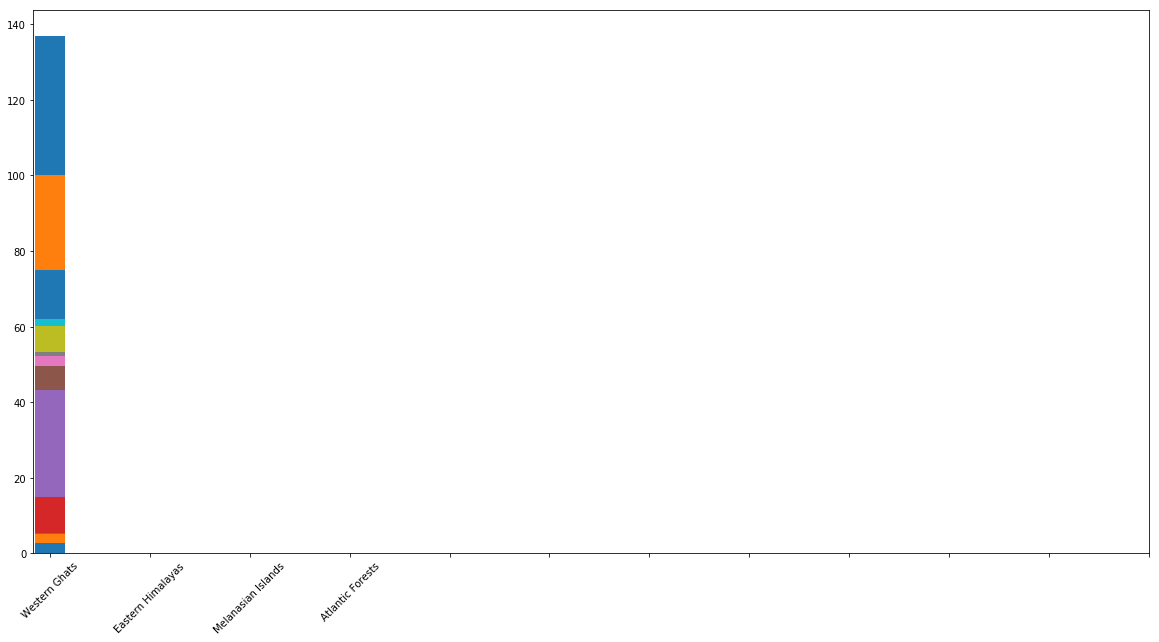

In [13]:
p = plt.figure(figsize=(20,10))
p1 = plt.bar(data_lab[0], data_ghats[0], width=0.3)
p2 = plt.bar(data_lab[0], new_data_ghats[1], width=0.3, bottom = new_data_ghats[0])
p3 = plt.bar(data_lab[0], new_data_ghats[2], width=0.3, bottom = new_data_ghats[1])
p4 = plt.bar(data_lab[0], new_data_ghats[3], width=0.3, bottom = new_data_ghats[2])
p5 = plt.bar(data_lab[0], new_data_ghats[4], width=0.3, bottom = new_data_ghats[3])
p6 = plt.bar(data_lab[0], new_data_ghats[5], width=0.3, bottom = new_data_ghats[4])
p7 = plt.bar(data_lab[0], new_data_ghats[6], width=0.3, bottom = new_data_ghats[5])
p8 = plt.bar(data_lab[0], new_data_ghats[7], width=0.3, bottom = new_data_ghats[6])
p9 = plt.bar(data_lab[0], new_data_ghats[8], width=0.3, bottom = new_data_ghats[7])
p10 = plt.bar(data_lab[0], new_data_ghats[9], width=0.3, bottom = new_data_ghats[8])
p11 = plt.bar(data_lab[0], new_data_ghats[10], width=0.3, bottom = new_data_ghats[9])
p1 = plt.bar(data_lab[0], new_data_ghats[11], width=0.3, bottom = new_data_ghats[10])
plt.xticks(data_lab, ['Western Ghats', 'Eastern Himalayas','Melanasian Islands',' Atlantic Forests'], rotation = 45)

In [14]:
len(viridis.colors)

12

In [110]:
type(datas)

list

In [43]:
topic_distribution = lda_model.get_document_topics(corpus, minimum_probability = 0)

In [75]:
lda_model.show_topics(-1, num_words = 20)

[(0,
  '0.070*"mammal" + 0.041*"urban" + 0.033*"standard" + 0.031*"extinct" + 0.022*"gene" + 0.019*"peninsula" + 0.018*"phylogenetic" + 0.018*"difficulty" + 0.017*"taxonomy" + 0.016*"carnivore" + 0.015*"census" + 0.014*"introduce" + 0.013*"greatly" + 0.013*"together" + 0.013*"park" + 0.012*"rural" + 0.011*"city" + 0.011*"biogeographic" + 0.010*"domestic" + 0.010*"livestock"'),
 (1,
  '0.033*"hunt" + 0.031*"people" + 0.019*"systematic" + 0.017*"climate_change" + 0.017*"climate" + 0.016*"valley" + 0.015*"climatic" + 0.013*"description" + 0.013*"arise" + 0.013*"inadequate" + 0.013*"sustainable" + 0.012*"scenario" + 0.011*"commercial" + 0.011*"evergreen" + 0.011*"incorporate" + 0.011*"vulnerability" + 0.011*"construction" + 0.011*"society" + 0.010*"change" + 0.010*"apparently"'),
 (2,
  '0.053*"nutrient" + 0.044*"social" + 0.037*"flower" + 0.035*"pollen" + 0.022*"concentration" + 0.019*"semi_natural" + 0.015*"adoption" + 0.013*"trait" + 0.013*"competition" + 0.013*"fluctuation" + 0.013*"re

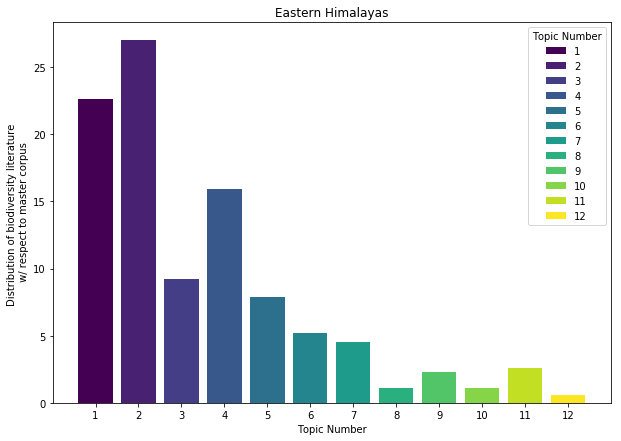

In [9]:
import matplotlib.pylab as plt
import numpy as np

labels = np.arange(1, 13)
colormap = plt.cm.get_cmap('viridis')
datas = [{'color': viridis.colors[i], 'height':data_him[i]} for i in range(0, len(viridis.colors))]

i=1
plt.subplots(figsize=(10, 7))
for data in datas:
    plt.bar(i, data['height'], align='center', color=data['color'])
    i+=1
pos = [i for i in range(0, len(datas))]
plt.xticks(pos, labels)
plt.xlabel("Topic Number")
plt.ylabel("Distribution of biodiversity literature \n w/ respect to master corpus")
plt.title('Eastern Himalayas')
plt.xticks(data_labels)
plt.legend(labels, title = 'Topic Number')
plt.show()

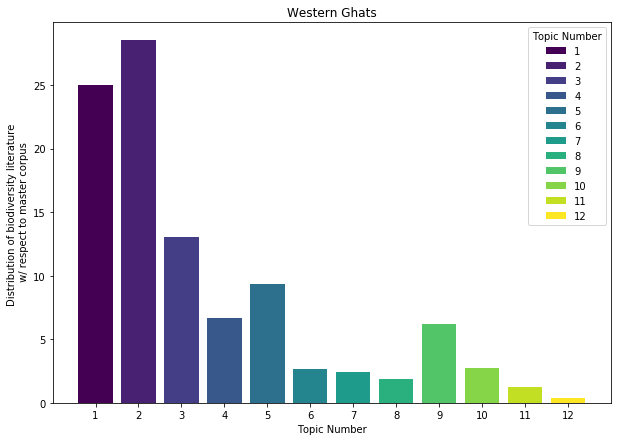

In [6]:
import matplotlib.pylab as plt
import numpy as np

datas = [{'color': viridis.colors[i], 'height':data_ghats[i]} for i in range(0, len(viridis.colors))]

labels = np.arange(1, 13)

i=1
plt.subplots(figsize=(10, 7))
for data in datas:
    plt.bar(i, data['height'], align='center', color=data['color'])
    i+=1
pos = [i for i in range(0, len(datas))]
plt.xticks(pos, labels)
plt.xlabel("Topic Number")
plt.ylabel("Distribution of biodiversity literature \n w/ respect to master corpus")
plt.title('Western Ghats')
plt.xticks(data_labels)
plt.legend(labels, loc = 'best', title = 'Topic Number', )
plt.show()

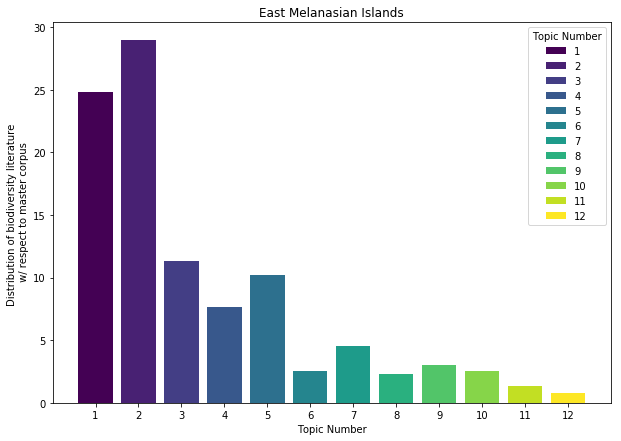

In [12]:
import matplotlib.pylab as plt
import numpy as np

datas = [{'color': viridis.colors[i], 'height':data_islands[i]} for i in range(0, len(viridis.colors))]

labels = np.arange(1, 13)

i=1
plt.subplots(figsize=(10, 7))
for data in datas:
    plt.bar(i, data['height'], align='center', color=data['color'])
    i+=1
pos = [i for i in range(0, len(datas))]
plt.xticks(pos, labels)
plt.xlabel("Topic Number")
plt.ylabel("Distribution of biodiversity literature \n w/ respect to master corpus")
plt.title('East Melanasian Islands')
plt.xticks(data_labels)
plt.legend(labels, loc = 'best', title = 'Topic Number', )
plt.show()

In [53]:
cols = [color for color in viridis.colors]

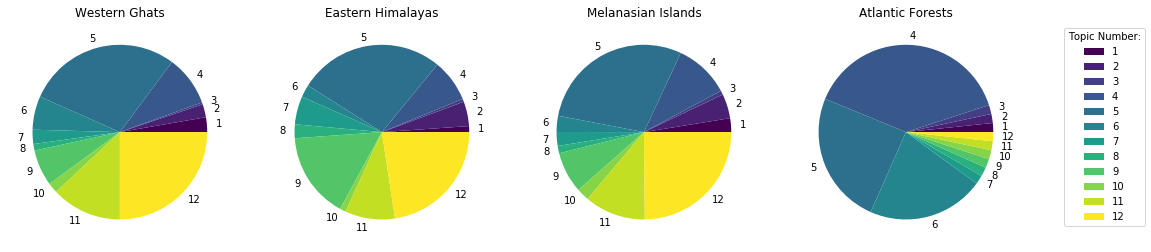

In [41]:
import matplotlib.colors as mcolors
cols = [color for  color in viridis.colors]  # more colors: 'mcolors.XKCD_COLORS'
fig, ax = plt.subplots(1, 4, figsize=(18, 18))
ax[0].pie(data_ghats, labels = data_labels, colors = cols)
ax[0].set_title('Western Ghats', loc = 'center')
ax[1].pie(data_him, labels = data_labels, colors = cols)
ax[1].set_title('Eastern Himalayas', loc = 'center')
ax[2].pie(data_islands, labels = data_labels, colors = cols)
ax[2].set_title('Melanasian Islands', loc = 'center')
ax[3].pie(data_forests, labels = data_labels, colors = cols)
ax[3].set_title('Atlantic Forests', loc = 'center')
plt.legend(data_labels, loc= 'upper left', bbox_to_anchor = (1.2, 0, 0.5, 1), title="Topic Number:")
plt.viridis()
plt.show()

In [36]:
vis

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
11     37.817173        1       1 -0.317037  0.031738
4      31.456345        1       2 -0.297547  0.107870
10      8.202921        1       3 -0.204476 -0.055713
8       7.000277        1       4 -0.111004 -0.238273
3       5.913970        1       5 -0.097848  0.227758
6       2.851634        1       6 -0.001512 -0.232949
1       1.653463        1       7  0.148263  0.068872
9       1.638315        1       8  0.150440 -0.018081
5       1.173970        1       9  0.150620  0.053984
0       1.014442        1      10  0.185774  0.015144
7       0.663275        1      11  0.197799  0.018059
2       0.614215        1      12  0.196526  0.021592, topic_info=      Category         Freq            Term        Total  loglift  logprob
4620   Default  6696.000000          forest  6696.000000  30.0000  30.0000
7883   Default  3265.000000           plant  3265.000000  29.0000  29.0000
14211  Default  2826.000000      population  2826.000000  28.0000  28.0000
7352   Default  1942.000000            tree  1942.000000  27.0000  27.0000
21187  Default  5196.000000    conservation  5196.000000  26.0000  26.0000
6933   Default  3049.000000        richness  3049.000000  25.0000  25.0000
12583  Default  1030.000000            soil  1030.000000  24.0000  24.0000
3847   Default  1061.000000         endemic  1061.000000  23.0000  23.0000
10833  Default  1197.000000            bird  1197.000000  22.0000  22.0000
13506  Default  4824.000000         habitat  4824.000000  21.0000  21.0000
1297   Default  4765.000000       diversity  4765.000000  20.0000  20.0000
12570  Default  1629.000000    distribution  1629.000000  19.0000  19.0000
1600   Default   852.000000          island   852.000000  18.0000  18.0000
8270   Default  1031.000000            taxa  1031.000000  17.0000  17.0000
22683  Default  2217.000000            area  2217.000000  16.0000  16.0000
2717   Default  1560.000000          region  1560.000000  15.0000  15.0000
12594  Default  2767.000000          number  2767.000000  14.0000  14.0000
13098  Default  3750.000000    biodiversity  3750.000000  13.0000  13.0000
23514  Default   617.000000          native   617.000000  12.0000  12.0000
9706   Default  3193.000000            site  3193.000000  11.0000  11.0000
1869   Default  1527.000000          change  1527.000000  10.0000  10.0000
8832   Default   828.000000            rare   828.000000   9.0000   9.0000
23699  Default   841.000000         genetic   841.000000   8.0000   8.0000
19339  Default  1158.000000           model  1158.000000   7.0000   7.0000
13164  Default   761.000000            seed   761.000000   6.0000   6.0000
18541  Default  1475.000000           total  1475.000000   5.0000   5.0000
1189   Default   831.000000            plot   831.000000   4.0000   4.0000
18736  Default  1638.000000          sample  1638.000000   3.0000   3.0000
19809  Default  1155.000000           range  1155.000000   2.0000   2.0000
3521   Default  1459.000000         pattern  1459.000000   1.0000   1.0000
...        ...          ...             ...          ...      ...      ...
19225  Topic12    69.405220   concentration    70.590538   5.0756  -3.7949
18927  Topic12    57.891911    semi_natural    59.077209   5.0723  -3.9763
17385  Topic12    45.515293        adoption    46.700695   5.0669  -4.2168
16814  Topic12    40.166451     competition    41.351749   5.0635  -4.3419
14677  Topic12    37.235420           sheep    38.420746   5.0612  -4.4176
14802  Topic12    35.814816      pollinator    37.000103   5.0600  -4.4565
23780  Topic12    35.456909             bee    36.642227   5.0597  -4.4666
10522  Topic12    31.337463     pollination    32.522755   5.0555  -4.5901
690    Topic12    29.019400        constant    30.204737   5.0525  -4.6669
10891  Topic12    27.772173     predominant    28.957518   5.0508  -4.7109
18912  Topic12    22.861277       technical    24.0

In [12]:
'''Builds the actual LDA model that will be used for the visualization and inference'''
lda_model = gensim.models.ldamodel.LdaModel(corpus = corpus, id2word = id2word, num_topics = 12, random_state = 100, update_every = 1, chunksize = 100, passes = 10, alpha = 'symmetric', per_word_topics = True)

doc_lda = lda_model[corpus]

perplexity_score = lda_model.log_perplexity(corpus)

perplexity_status_key = "Issued perplexity:"+" "+str(perplexity_score)

status_logger(status_logger_name, perplexity_status_key)

nlp_engine_main_end_status_key = "Idling the NLP Engine"
status_logger(status_logger_name, nlp_engine_main_end_status_key)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[INFO]18:11:26 Generating bigrams
[INFO]18:11:26 Generating word bigrams
[INFO]18:11:30 Generated word bigrams
[INFO]18:11:31 Beginning lemmatization
[INFO]18:11:49 Ending lemmatization
[INFO]18:12:24 Issued perplexity: -9.42808103444275
[INFO]18:12:24 Idling the NLP Engine


Presenting the topics of the trained ```LDA``` model here.

In [13]:
lda_model.print_topics()

[(0,
  '0.070*"mammal" + 0.041*"urban" + 0.033*"standard" + 0.031*"extinct" + 0.022*"gene" + 0.019*"peninsula" + 0.018*"phylogenetic" + 0.018*"difficulty" + 0.017*"taxonomy" + 0.016*"carnivore"'),
 (1,
  '0.033*"hunt" + 0.031*"people" + 0.019*"systematic" + 0.017*"climate_change" + 0.017*"climate" + 0.016*"valley" + 0.015*"climatic" + 0.013*"description" + 0.013*"arise" + 0.013*"inadequate"'),
 (2,
  '0.053*"nutrient" + 0.044*"social" + 0.037*"flower" + 0.035*"pollen" + 0.022*"concentration" + 0.019*"semi_natural" + 0.015*"adoption" + 0.013*"trait" + 0.013*"competition" + 0.013*"fluctuation"'),
 (3,
  '0.040*"bird" + 0.024*"population" + 0.016*"year" + 0.016*"wildlife" + 0.016*"decline" + 0.013*"km" + 0.011*"wetland" + 0.011*"nest" + 0.010*"fire" + 0.010*"animal"'),
 (4,
  '0.030*"conservation" + 0.020*"biodiversity" + 0.009*"protect" + 0.008*"management" + 0.007*"resource" + 0.007*"base" + 0.007*"datum" + 0.006*"reserve" + 0.006*"information" + 0.006*"development"'),
 (5,
  '0.068*"so

Declaring the ```mallet``` path here. Part of the GitHub package that you've cloned.

In [14]:
mallet_path = '/home/sarthak/projects/Bias/mallet-2.0.8/bin/mallet'

Building the ```LDA mallet``` model here, to generate the representative documents, run the coherence tests and issue perplexity here.

In [15]:
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=12, id2word=id2word)

Just checking out the topics of the ```LDA mallet``` model here.

In [16]:
pprint(ldamallet.show_topics(formatted=False))

[(7,
  [('forest', 0.16080377200128368),
   ('tree', 0.05137130020489274),
   ('composition', 0.014984324471105186),
   ('stand', 0.01463872225925103),
   ('density', 0.014268434175121579),
   ('fragment', 0.014070947196919203),
   ('disturbance', 0.01308351230590733),
   ('plantation', 0.012589794860401392),
   ('ant', 0.011528302352563628),
   ('edge', 0.011158014268434175)]),
 (2,
  [('population', 0.06735322275985199),
   ('bird', 0.03529381323259244),
   ('habitat', 0.02429684063446063),
   ('island', 0.019872176365565243),
   ('native', 0.01580976531166714),
   ('mammal', 0.012652987295262246),
   ('large', 0.01260123683597692),
   ('density', 0.011022847827774471),
   ('individual', 0.010531218464563874),
   ('size', 0.009987838642067948)]),
 (0,
  [('habitat', 0.0816044573292263),
   ('landscape', 0.038480703025910494),
   ('richness', 0.03691791991302772),
   ('diversity', 0.023577640876970465),
   ('scale', 0.021222141692335567),
   ('factor', 0.018209820619677478),
   ('abun

Presenting the "Coherence" of the model here. Coherence is a proxy for how well the model has been built and trained.

In [17]:
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=textual_data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.4637534762330899


Presenting the coherence here for a bunch of trained models. Will be eventually selecting the ```optimal_model``` as the ```lda_model```, to get the representative documents with corresponding ```num_topics```.

In [18]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

Computing coherence from the previously generated ```mallet``` models, to find the model with the best coherence, and thereby the best model.

In [19]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=textual_data_lemmatized, start=2, limit=40, step=6)

Plotting the computed coherence scores here for the models that we generated.

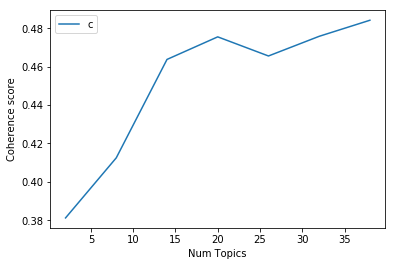

In [20]:
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

Declaring the ```optimal_model``` as the previously generated ```ldamallet``` model.

In [21]:
optimal_model = ldamallet

Presenting the topics of the ```ldamallet``` model here.

In [22]:
model_topics = optimal_model.show_topics(formatted=False)
print(model_topics)

[(7, [('forest', 0.16080377200128368), ('tree', 0.05137130020489274), ('composition', 0.014984324471105186), ('stand', 0.01463872225925103), ('density', 0.014268434175121579), ('fragment', 0.014070947196919203), ('disturbance', 0.01308351230590733), ('plantation', 0.012589794860401392), ('ant', 0.011528302352563628), ('edge', 0.011158014268434175)]), (6, [('human', 0.029058035353943013), ('land', 0.018376516802539888), ('local', 0.016250975327575537), ('activity', 0.016062636209540723), ('resource', 0.01329136061559986), ('wildlife', 0.012887776791239541), ('natural', 0.010520085021658998), ('wild', 0.009981973255845239), ('traditional', 0.008959560900799095), ('management', 0.00863669384131084)]), (10, [('biodiversity', 0.03999576540334533), ('conservation', 0.03398263815371586), ('management', 0.024073681981791235), ('research', 0.015032818124073682), ('knowledge', 0.011475756934152022), ('approach', 0.009930129155197967), ('policy', 0.009908956171924624), ('process', 0.0098454372221

```num_words``` dictates the number of keywords to be presented with each topic.

In [23]:
pprint(optimal_model.print_topics(num_words=40))

[(0,
  '0.082*"habitat" + 0.038*"landscape" + 0.037*"richness" + 0.024*"diversity" '
  '+ 0.021*"scale" + 0.018*"factor" + 0.016*"abundance" + 0.016*"pattern" + '
  '0.015*"variable" + 0.015*"influence" + 0.014*"effect" + 0.014*"patch" + '
  '0.013*"environmental" + 0.012*"relationship" + 0.011*"group" + '
  '0.011*"butterfly" + 0.010*"structure" + 0.009*"important" + '
  '0.009*"functional" + 0.009*"explain" + 0.009*"spatial" + 0.008*"relate" + '
  '0.008*"community" + 0.008*"urban" + 0.008*"trait" + 0.008*"variation" + '
  '0.008*"type" + 0.007*"affect" + 0.007*"result" + 0.007*"ecological" + '
  '0.007*"local" + 0.007*"size" + 0.007*"characteristic" + '
  '0.006*"fragmentation" + 0.006*"examine" + 0.006*"heterogeneity" + '
  '0.006*"large" + 0.006*"matrix" + 0.006*"level" + 0.006*"area"'),
 (1,
  '0.036*"number" + 0.031*"diversity" + 0.028*"sample" + 0.026*"total" + '
  '0.025*"record" + 0.023*"taxa" + 0.021*"area" + 0.020*"region" + '
  '0.020*"group" + 0.019*"richness" + 0.016*"si

This function computes the dominant topic in each sentence. We use this meta-data as a part of our framework to understand under which areas of research do the publications fall in, and also to label each of the ```pyLDAvis``` topics.

In [24]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=textual_data):
    sent_topics_df = pd.DataFrame()
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

Generating the ```dataframes``` here which contains the dominant topics for each abstract.

In [25]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=textual_data)
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,11.0,0.2700,"community, soil, ecosystem, water, river, envi...",[Abstract: 'Maintenance of soil health is cent...
1,1,3.0,0.4129,"plant, distribution, genetic, region, diversit...",[Abstract: 'Plant invasion is highly responsiv...
2,2,8.0,0.3100,"datum, model, base, distribution, method, info...","[Abstract: 'Globally, treeline in mountain lan..."
3,3,8.0,0.2920,"datum, model, base, distribution, method, info...",[Abstract: 'Forests play a crucial role by reg...
4,4,3.0,0.3187,"plant, distribution, genetic, region, diversit...",[Abstract: 'The analysis of species distributi...
5,5,3.0,0.1993,"plant, distribution, genetic, region, diversit...",[Abstract: 'The Himalayan ecosystem is one of ...
6,6,8.0,0.3002,"datum, model, base, distribution, method, info...","[Abstract: 'In an era of climate change, predi..."
7,7,2.0,0.2573,"population, bird, habitat, island, native, mam...",[Abstract: 'The relationship and its key predi...
8,8,3.0,0.5099,"plant, distribution, genetic, region, diversit...",[Abstract: 'Climate change effects on Himalaya...
9,9,8.0,0.1899,"datum, model, base, distribution, method, info...",[Abstract: 'With the threats of climate change...


Saving the ```dataframe``` to disc for analysis.

In [26]:
df_dominant_topic.to_csv(session_folder_name+'/Master_Topic_Per_Centence.csv')

Here we find the most representative document for each topic, and contain it in a ```dataframe``` and save it as a ```.csv```

In [27]:
sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')
for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], axis=0)

In [28]:
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]
sent_topics_sorteddf_mallet.head()
sent_topics_sorteddf_mallet.to_csv(session_folder_name+'/Master_Topics_Contribution.csv')

Here, we find the number of documents for each topic.

In [29]:
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

Here, we find the percentage of documents falling under each topic.

In [30]:
topic_contribution = round(topic_counts/topic_counts.sum(), 4)
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

Presenting the dominant topics in each sentence here.

In [31]:
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,11.0,"community, soil, ecosystem, water, river, envi...",626.0,0.1323
1,3.0,"plant, distribution, genetic, region, diversit...",307.0,0.0649
2,8.0,"datum, model, base, distribution, method, info...",388.0,0.0820
3,8.0,"datum, model, base, distribution, method, info...",322.0,0.0680
4,3.0,"plant, distribution, genetic, region, diversit...",384.0,0.0811
5,3.0,"plant, distribution, genetic, region, diversit...",230.0,0.0486
6,8.0,"datum, model, base, distribution, method, info...",343.0,0.0725
7,2.0,"population, bird, habitat, island, native, mam...",470.0,0.0993
8,3.0,"plant, distribution, genetic, region, diversit...",341.0,0.0720
9,8.0,"datum, model, base, distribution, method, info...",348.0,0.0735


Saving it to a ```.csv``` bucket here.

In [32]:
df_dominant_topics.to_csv(session_folder_name+'/Master_Topics.csv')

Generating the visualization here from the ```lda_model```. We use this to label the broad areas of research, in syn which the representative documents generated above.

In [82]:
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)

/home/sarthak/.local/lib/python3.5/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


Enabling the visualizations in the notebook here.

In [83]:
pyLDAvis.enable_notebook()

In [84]:
vis

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
11     37.818871        1       1 -0.317037  0.031738
4      31.455793        1       2 -0.297547  0.107870
10      8.201900        1       3 -0.204476 -0.055713
8       7.001565        1       4 -0.111004 -0.238273
3       5.914448        1       5 -0.097848  0.227758
6       2.851061        1       6 -0.001512 -0.232949
1       1.652339        1       7  0.148263  0.068872
9       1.638297        1       8  0.150440 -0.018081
5       1.173973        1       9  0.150620  0.053984
0       1.014496        1      10  0.185775  0.015144
7       0.663248        1      11  0.197799  0.018058
2       0.614005        1      12  0.196526  0.021592, topic_info=      Category         Freq            Term        Total  loglift  logprob
6580   Default  6698.000000          forest  6698.000000  30.0000  30.0000
23491  Default  3265.000000           plant  3265.000000  29.0000  29.0000
6263   Default  2826.000000      population  2826.000000  28.0000  28.0000
17014  Default  1942.000000            tree  1942.000000  27.0000  27.0000
17273  Default  5196.000000    conservation  5196.000000  26.0000  26.0000
16000  Default  3049.000000        richness  3049.000000  25.0000  25.0000
5741   Default  1030.000000            soil  1030.000000  24.0000  24.0000
13916  Default  1061.000000         endemic  1061.000000  23.0000  23.0000
17096  Default  1197.000000            bird  1197.000000  22.0000  22.0000
8324   Default  4825.000000         habitat  4825.000000  21.0000  21.0000
3521   Default  4765.000000       diversity  4765.000000  20.0000  20.0000
17888  Default  1629.000000    distribution  1629.000000  19.0000  19.0000
5784   Default   852.000000          island   852.000000  18.0000  18.0000
20544  Default  1031.000000            taxa  1031.000000  17.0000  17.0000
9176   Default  2217.000000            area  2217.000000  16.0000  16.0000
8655   Default  1560.000000          region  1560.000000  15.0000  15.0000
17295  Default  2767.000000          number  2767.000000  14.0000  14.0000
20229  Default  3750.000000    biodiversity  3750.000000  13.0000  13.0000
3971   Default   617.000000          native   617.000000  12.0000  12.0000
22283  Default  3193.000000            site  3193.000000  11.0000  11.0000
20343  Default  1527.000000          change  1527.000000  10.0000  10.0000
8830   Default   828.000000            rare   828.000000   9.0000   9.0000
9678   Default   841.000000         genetic   841.000000   8.0000   8.0000
16732  Default  1158.000000           model  1158.000000   7.0000   7.0000
15977  Default   760.000000            seed   760.000000   6.0000   6.0000
16808  Default  1475.000000           total  1475.000000   5.0000   5.0000
21409  Default   831.000000            plot   831.000000   4.0000   4.0000
23365  Default  1638.000000          sample  1638.000000   3.0000   3.0000
23156  Default  1155.000000           range  1155.000000   2.0000   2.0000
8018   Default  1459.000000         pattern  1459.000000   1.0000   1.0000
...        ...          ...             ...          ...      ...      ...
14040  Topic12    69.381561   concentration    70.566811   5.0760  -3.7949
21282  Topic12    57.872173    semi_natural    59.057404   5.0726  -3.9763
14237  Topic12    45.499779        adoption    46.685112   5.0672  -4.2168
1156   Topic12    40.152756     competition    41.337986   5.0638  -4.3419
3890   Topic12    37.222729           sheep    38.407986   5.0616  -4.4176
7908   Topic12    35.802608      pollinator    36.987823   5.0604  -4.4565
22572  Topic12    35.444820             bee    36.630066   5.0600  -4.4666
4744   Topic12    31.326780     pollination    32.512001   5.0558  -4.5901
8211   Topic12    29.009508        constant    30.194777   5.0529  -4.6669
17375  Topic12    27.762705     predominant    28.947981   5.0511  -4.7109
2360   Topic12    22.853483       technical    24.0

Saving the visualization to the disk, as an ```.html``` file in the sessions folder.

In [85]:
pyLDAvis.save_html(vis, 'Master.html')

Presenting the ```pyLDAvis``` visualization here.

In [37]:
topics = optimal_model.show_topics(num_topics = -1, formatted=False)

In [38]:
plt.show()

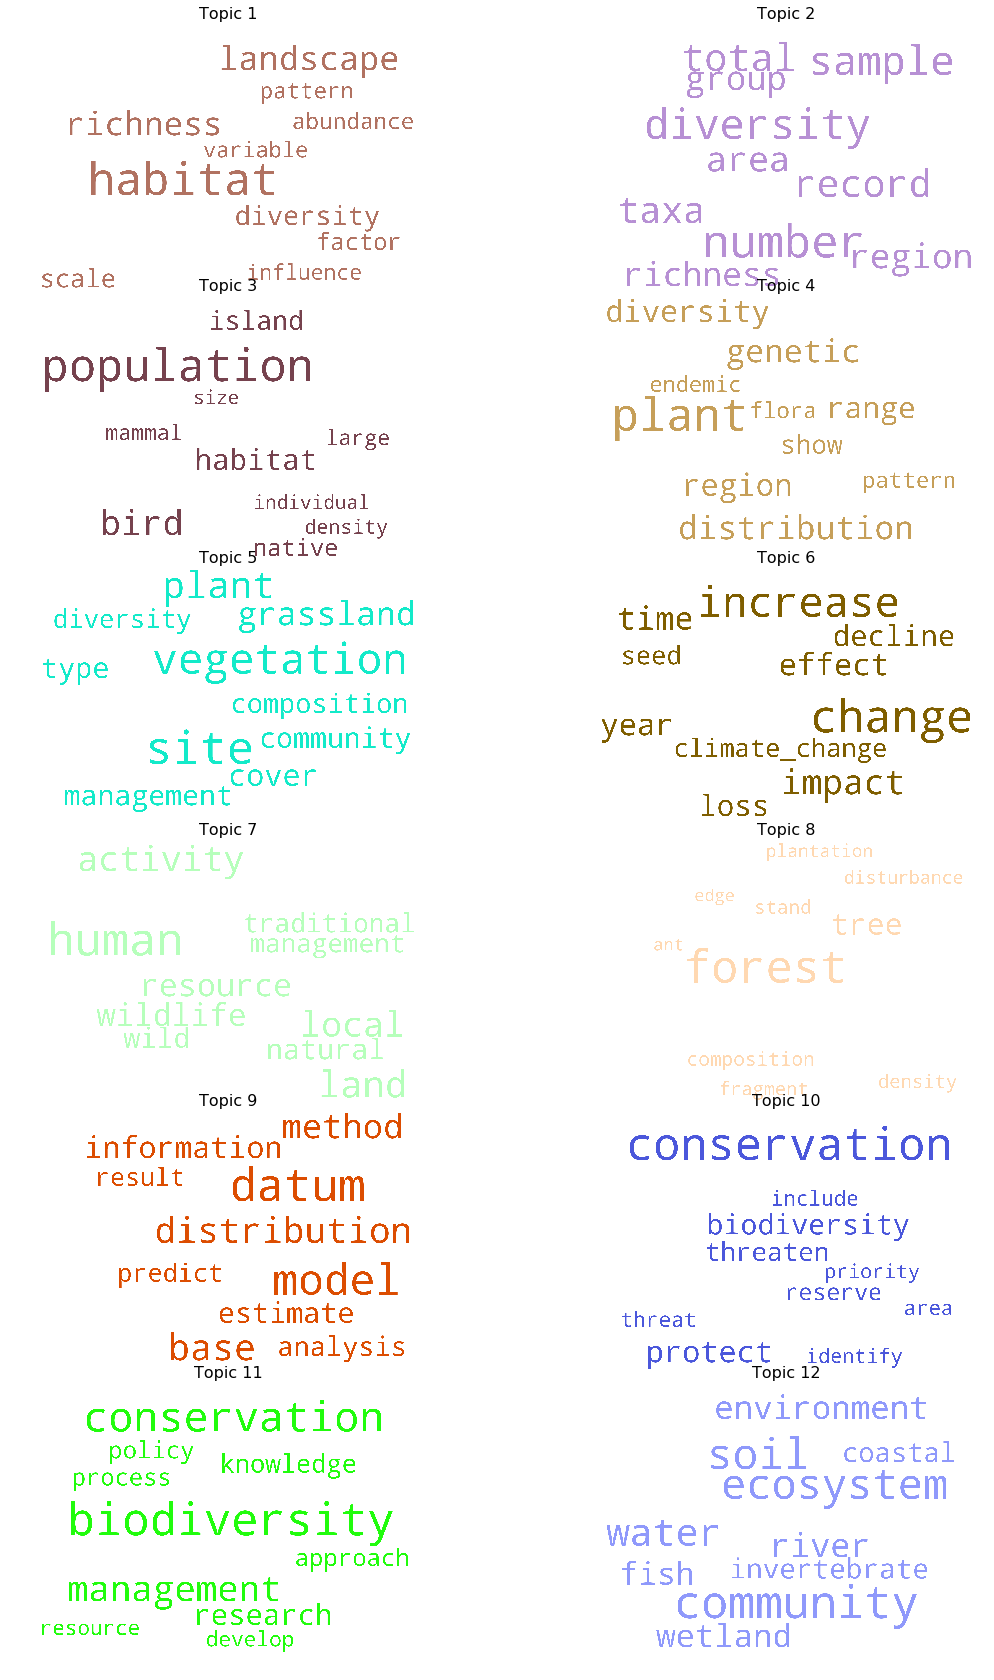

In [39]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.XKCD_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab8',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

fig, axes = plt.subplots(6, 2, figsize = (20, 30), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i+1), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.show()

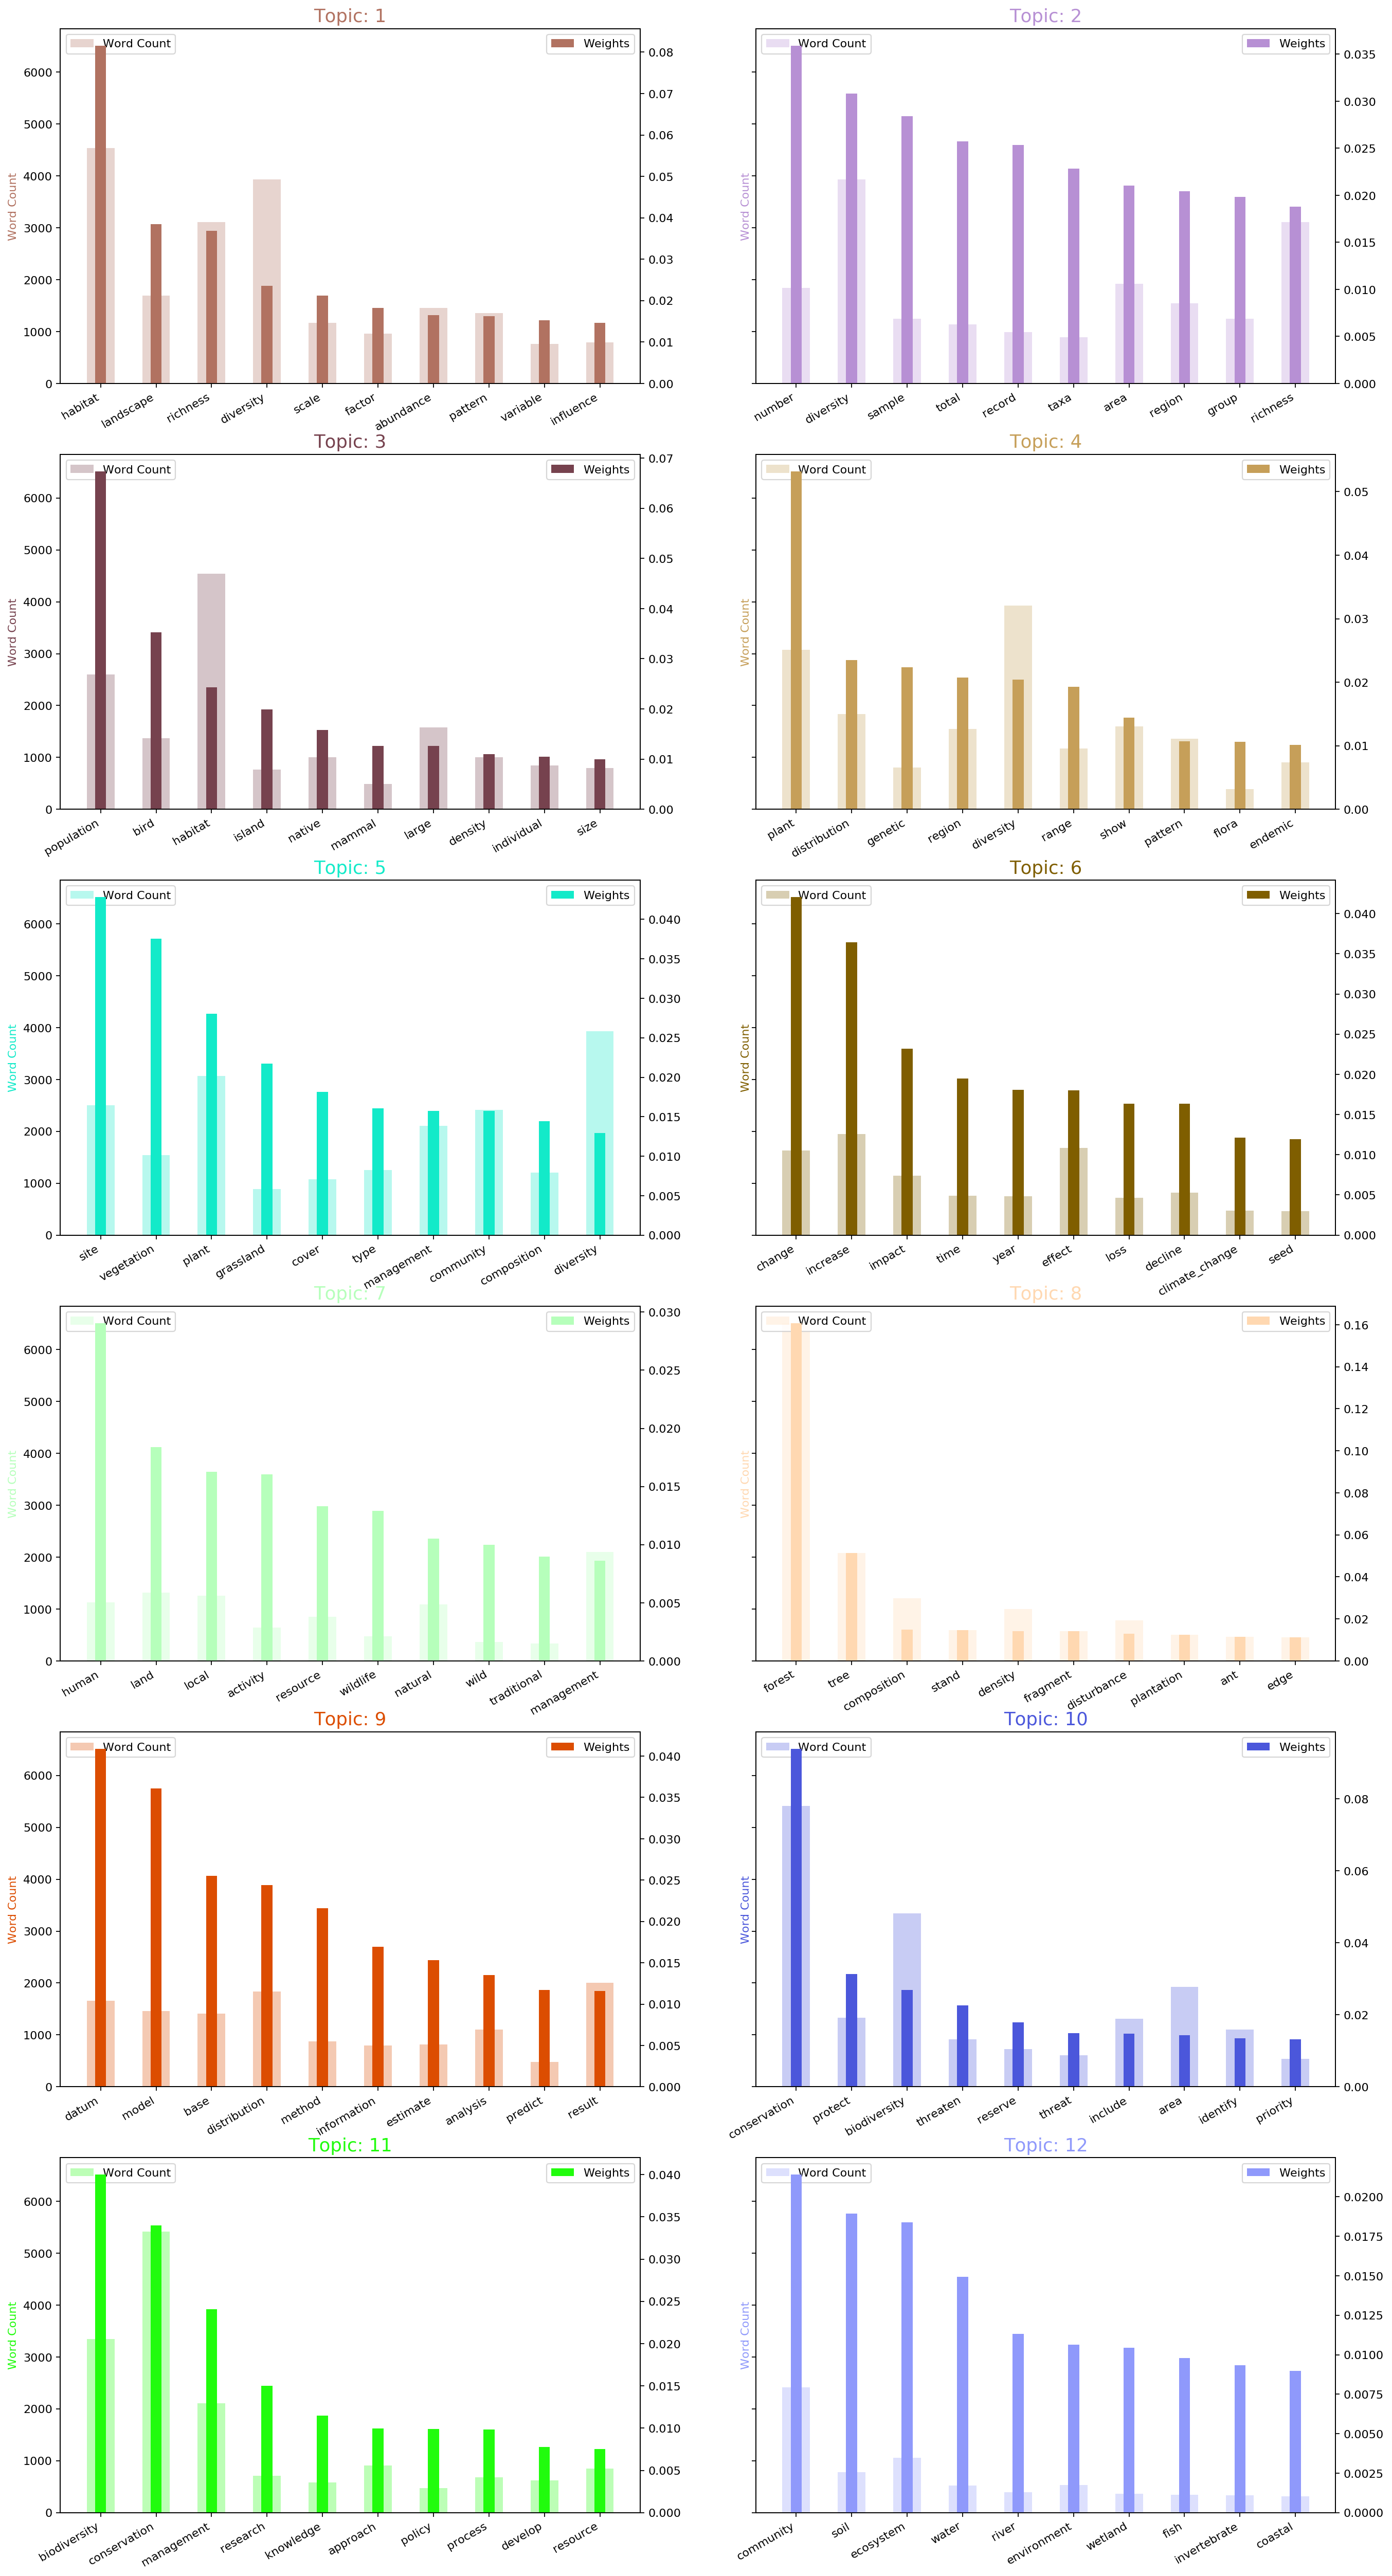

In [40]:
from collections import Counter
topics = optimal_model.show_topics(num_topics = -1, formatted=False)
data_flat = [w for w_list in textual_data_lemmatized for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(6, 2, figsize=(20, 40), sharey=True, dpi=160)
cols = [color for name, color in mcolors.XKCD_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax.set_title('Topic: ' + str(i+1), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=True)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')
    
plt.savefig(session_folder_name + '/CorpusTopic12.pdf')
plt.show()

In [41]:
import dill

In [42]:
dill.dump_session('Corpus.db')